# Linear Gaussian State Space Model

As a first approach to the problem of choosing a proposal for Sequential Monte Carlo (SMC), let's consider a simple linear gaussian state space model. This way, it will be possible to compare obtained results to those provided by a Kalman filter.

We will consider the following model: 
$$
\begin{array}{l}
X_{t+1} = A X_t + W_t\\
Y_{t+1} = B X_t + V_t
\end{array}
$$
where $\ X_0 \sim \mathcal{N}(0, I), \ W_t \sim \mathcal{N}(0,Q) \ \textrm{and} \ V_t \sim \mathcal{N}(0, R)$. Our interest is to estimate the latent variables $X_{1:T}$.

In this scenario, we have the following distributions:
- Prior: $\begin{cases}f (x_0) = \mathcal{N} (x_0; 0, I);\\ f(x_t | x_{t-1}) = \mathcal{N}(x_t; A x_{t-1},Q Q^T);\end{cases}$
- Likelihood: $g (y_t | x_t) = \mathcal{N}(y_t; B x_{t}, R R^T)$.


## Dataset:
First, we will consider a one-dimensional generated dataset. This dataset was generated from the model above using $A = 0.95, \ B = 1, \ Q = 1 \ \textrm{and} \ R = 1$, so that's the model we will consider. 

In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import distributions
from torch.distributions import Normal
from torch.distributions import MultivariateNormal
from torch import nn
from tqdm import tqdm
import scipy.stats as scipy
import math
import time

# Set matplotlib style
plt.style.use("ggplot")

# Set seed for reproductibility
seed_value = 42
torch.manual_seed(seed_value)
np.random.seed(seed_value)

In [2]:
# Reading data
with open("./data/gaussian_ssm_data1.txt", "r") as f:
    lines = f.readlines()
    Y = [float(i) for i in lines[1].split(',')[1:]]

In [3]:
# Converting to torch.tensor
y_seq = [torch.tensor([i]) for i in Y]
y_seq[:10]  # Printing the first 10 observations

[tensor([-0.1666]),
 tensor([-0.5247]),
 tensor([-0.6954]),
 tensor([-2.1302]),
 tensor([-2.0467]),
 tensor([-1.6577]),
 tensor([0.4692]),
 tensor([-0.8291]),
 tensor([0.3087]),
 tensor([1.2102])]

## Kalman Filter

The first approach to be consider is the Kalman filter, which is implemented by the code bellow, following the procedure described by \[1\]. We can interpret the result of this approach as our "ground truth", which enable comparisons with other approaches.

In [4]:
def KalmanFilter(Y, A, B, Q, R, x0, P0):
    '''
    Implements the Kalman Filter.

    Returns:
        A np.array with the estimates for the latent variables.
    ---
    >> Y: observed data (list)
    >> A: state transition matrix (np.array)
    >> B: observation matrix (np.array)
    >> Q: process noise covariance (np.array)
    >> R: observation noise covariance (np.array)
    >> x0: initial state estimate
    >> P0: initial covariance estimate
    '''
    # Initial estimates
    P = P0
    x_hat = x0

    D = P0.shape[0]  # Dimension
    
    estimates = []
    
    for y_t in Y:
        # Project into t+1
        x_ = A @ x_hat
        P_ = A @ P @ A.T + Q
        
        # Kalman Gain
        S = B @ P_ @  B.T + R
        K = P_ @ B.T @ np.linalg.inv(S)
        
        # Update Estimate
        innovation = y_t - B @ x_
        x_hat = x_ + K @ innovation 

        # Update Covariance
        P = (np.eye(D) - K @ B) @ P_

        estimates.append(x_hat)

    return np.array(estimates).reshape(len(estimates))


def kalman_log_likelihood(y, A, B, Q, R, x0, P0):
    '''
    Computes the log marginal likelihood using Kalman Filter.

    ---
    >> Y: observed data (list)
    >> A: state transition matrix (np.array)
    >> B: observation matrix (np.array)
    >> Q: process noise covariance (np.array)
    >> R: observation noise covariance (np.array)
    >> x0: initial state estimate
    >> P0: initial covariance estimate
    '''
    T = len(Y)#.shape
    n = x0.shape[0]
    
    x_pred = x0
    P_pred = P0
    log_likelihood = 0.0

    log_likelihoods = []

    for t in range(T):
        # Predict observation
        y_pred = B @ x_pred
        S = B @ P_pred @ B.T + R

        # Innovation
        innovation = Y[t] - y_pred

        # Log likelihood of y_t ~ N(H x_pred, S)
        dist = scipy.multivariate_normal(y_pred, S)
        # print(dist.logpdf(y[t]))
        # print(torch.tensor(y_pred), torch.tensor(S))
        # dist = torch.distributions.MultivariateNormal(torch.tensor([y_pred]), torch.tensor(S))
        log_likelihood += dist.logpdf(y[t])
        log_likelihoods.append(log_likelihood)

        # Kalman gain
        K = P_pred @ B.T @ np.linalg.inv(S)

        # Update state
        x_filt = x_pred + K @ innovation
        P_filt = (np.eye(n) - K @ B) @ P_pred

        # Predict next state
        x_pred = A @ x_filt
        P_pred = A @ P_filt @ A.T + Q

    return log_likelihoods


def kalman_variances(y, A, B, Q, R, x0, P0):
    '''
    Tracks the posterior variances from Kalman filtering.
    '''
    T = len(y)#.shape
    n = x0.shape[0]
    
    x_pred = x0
    P_pred = P0

    variances = np.zeros((T, n))

    for t in range(T):
        # Predict observation
        y_pred = B @ x_pred
        S = B @ P_pred @ B.T + R
        innovation = y[t] - y_pred

        # Kalman gain
        K = P_pred @ B.T @ np.linalg.inv(S)

        # Update state and covariance
        x_filt = x_pred + K @ innovation
        P_filt = (np.eye(n) - K @ B) @ P_pred

        # Store posterior variance
        variances[t] = np.diag(P_filt)

        # Predict next
        x_pred = A @ x_filt
        P_pred = A @ P_filt @ A.T + Q

    return variances


In [5]:
X_hat = KalmanFilter(Y, 
                     np.array([[0.95]]), 
                     np.array([[1]]), 
                     np.array([[1]]),
                     np.array([[1]]), 
                     np.array([0]),    # educated guess
                     np.array([[10]])  # high variance, because the guess is probably wrong
                    )

In [6]:
kalman_lik = kalman_log_likelihood(
    Y,
    np.array([[0.95]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([0]),    # educated guess
    np.array([[10]])  # high variance, because the guess is probably wrong
)

In [7]:
kalman_var = kalman_variances(
    Y,
    np.array([[0.95]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([[1]]),
    np.array([0]),    # educated guess
    np.array([[10]])  # high variance, because the guess is probably wrong
)

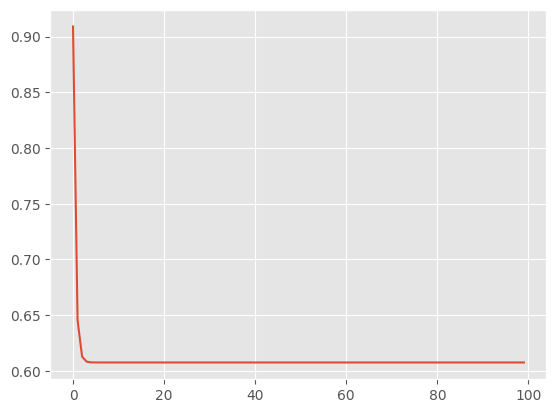

In [8]:
plt.plot(kalman_var)

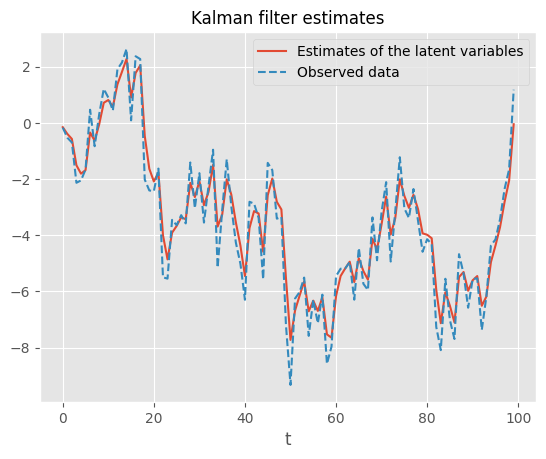

In [9]:
# Plotting the obtained estimates
plt.plot(X_hat, label='Estimates of the latent variables')
plt.plot(Y, ls='--',label='Observed data')
plt.xlabel("t")
plt.title("Kalman filter estimates",size=12)
plt.legend()

Text(0, 0.5, '$\\hat{p} (y_{1:t})$')

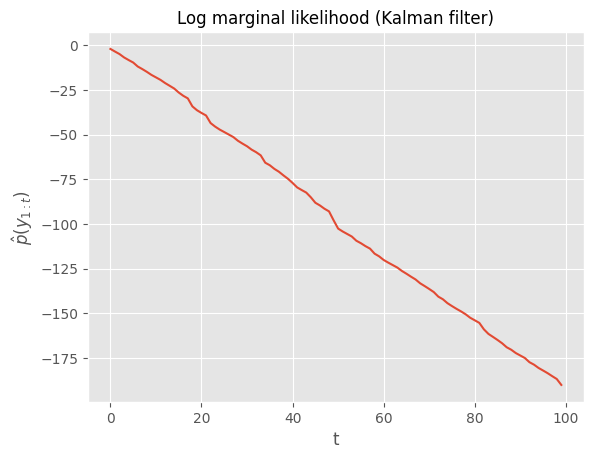

In [10]:
# Plotting estimates for log marginal likelihood
plt.plot(kalman_lik, label='kalman')
plt.title("Log marginal likelihood (Kalman filter)",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
# plt.legend()

## Sequential Monte Carlos approaches

All of the approaches considered are versions of Sequential Monte Carlo. As they are being applied to the same model and dataset, the prior and likelihood distributions are the same. The only difference studied in this work is the choice of proposal distribution. Therefore, we define belllow the prior and likelihood distributions to be used.

In [11]:
def likelihood(x_t):
    '''
    Defines g( y_t | x_t ).
    
    Returns:
        The torch.distribution of y_t given x_t. The 
        returned object allows sampling and evaluating
        the log pdf at a given point.
    ---
    >> x_t: (torch.tensor)
    '''
    return Normal(x_t, 1)
    
def prior(x_prev):
    '''
    Defines f(x_0) and f(x_t | x_{t-1}).

    Returns: 
        The torch.distribution of x_0 or of x_t given x_{t-1}.
        The returned object allows sampling and evaluating
        the log pdf at a given point.
    ---
    >> x_prev: (torch.tensor or None)
    '''
    if x_prev is None:
        # Initial distribution of process X_t
        return Normal(0,1)
    else:
        # Transition distribution of process X_t
        return Normal(0.95*x_prev, 1)

Also, we can already define some functions useful for evaluating each approach, such as effective sample size, log marginal likelihood estimates, and mean and variance of estimates.

In [12]:
def ESS(log_w): 
    '''
    Calculates the effective sample size.

    Returns:
        A torch.tensor with the effective sample size
        at each time step.
    ---
    >> log_w: the log weights of SMC through time steps (torch.tensor)
    '''
    log_w_norm = log_w - torch.logsumexp(log_w, dim=1, keepdim=True)
    w = torch.exp(log_w_norm)
    ess = 1.0 / torch.sum(w**2, dim=1)
    return ess


def log_marginal_likelihood(log_w):
    '''
    Returns the estimated log marginal likelihood of the data.

    ---
    >> log_w: the log weights of SMC through time steps (torch.tensor)
    '''
    T, N = log_w.shape
    marginal_likelihood = torch.zeros(T)
    for t in range(T):
        # Calculates the log marginal for 1, ..., t
        cur_logsumexp =  torch.logsumexp(log_w[:t+1, :], dim=1, keepdim=True)
        shape = cur_logsumexp.shape
        cur_marginal = torch.sum(cur_logsumexp - np.log(N) * torch.ones(shape))
        marginal_likelihood[t] = cur_marginal
    return marginal_likelihood

### SMC with prior as proposal

The first approach we will consider for comparison is the classical SMC with the prior distribution as the proposal.

In [13]:
def SMC_prior(y_seq, N, T, latent_dim=1):
    '''
    Apply SMC algorithm using the prior distribution
    as the proposal.

    Returns:
        log_w: obtained log weights (torch.tensor)
        x_particles: all particles generated (torch.tensor)
        ancestors: ancestors sampled through SMC (torch.tensor)
        x_estimates: final estimates for the latent data (torch.tensor)
    ---
    >> y_seq: observed data (list of torch.tensor)
    >> N: number of particles (int)
    >> T: number of time steps (int)
    >> latent_dim: dimension of the observed data (int)
    '''
    # Initialize
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    # Step 1
    x_t = prior(None).sample((N,latent_dim))
    x_particles[0] = x_t
    log_w[0] = likelihood(x_t).log_prob(y_seq[0]).squeeze()

    # Steps from 2 to T
    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        x_t = prior(x_prev).sample()
        x_particles[t] = x_t

        log_w[t] = likelihood(x_t).log_prob(y_seq[t]).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, b_T]
        if t > 0:
            b_T = ancestors[t, b_T]
    
    return log_w, x_particles, ancestors, x_estimates


In [14]:
N = 1000
T = 100
log_w_prior, x_part_prior, a_prior, x_prior = SMC_prior(y_seq, N, T)

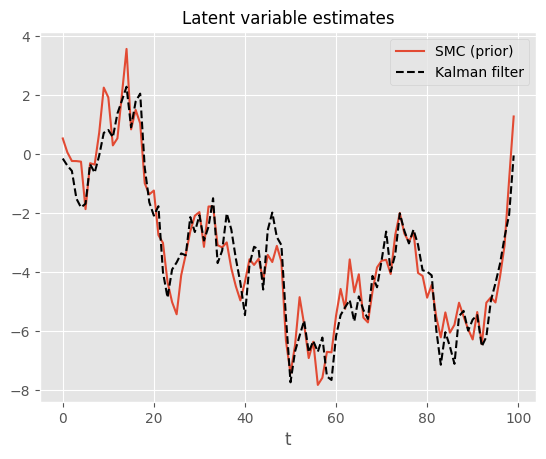

In [15]:
# Plotting estimates
plt.plot(x_prior.numpy(), label='SMC (prior)')
plt.plot(X_hat, label='Kalman filter', c='black',ls='--')
plt.xlabel('t')
plt.title('Latent variable estimates',size=12)
plt.legend()

(0.0, 1000.0)

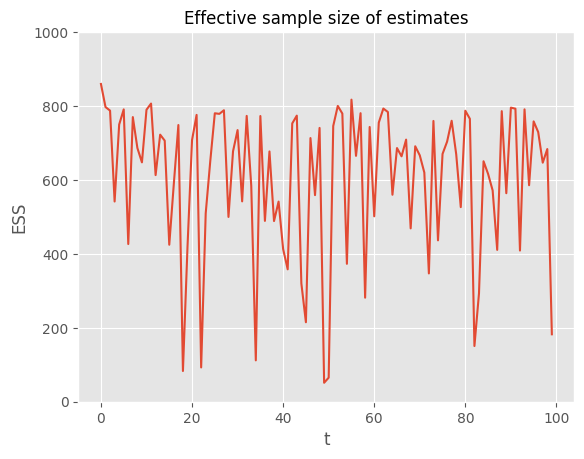

In [16]:
# Plotting ESS
ESS_prior = ESS(log_w_prior)
plt.plot(ESS_prior)
plt.title('Effective sample size of estimates',size=12)
plt.xlabel('t')
plt.ylabel('ESS')
plt.ylim((0,1000))

In [17]:
prior_lik = log_marginal_likelihood(log_w_prior)

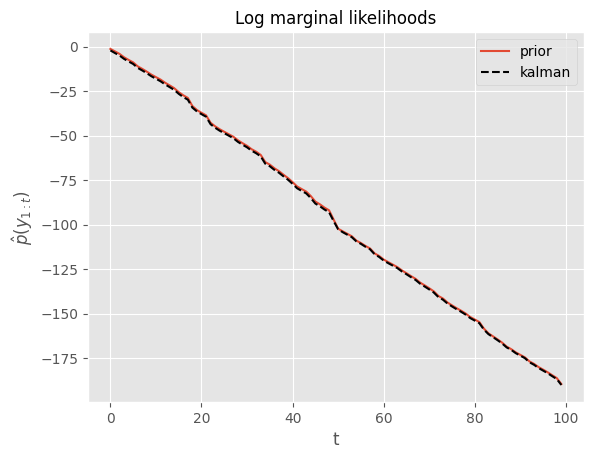

In [18]:
plt.plot(prior_lik, label='prior')
plt.plot(kalman_lik, label='kalman',ls='--',c='black')
plt.title("Log marginal likelihoods",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
plt.legend()

Text(0.5, 0, 't')

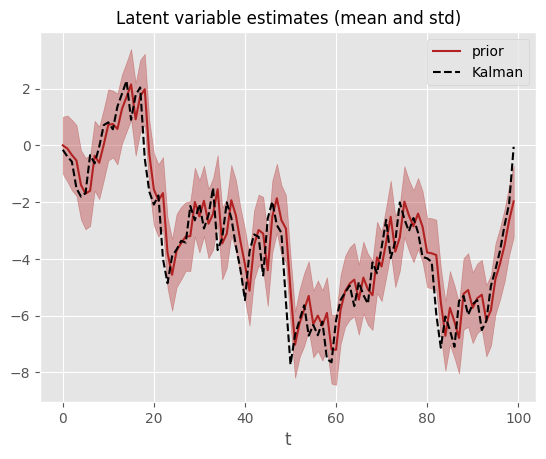

In [19]:
mu = x_part_prior.detach().mean(axis=1)
s = x_part_prior.detach().std(axis=1)
y1 = (mu - s).reshape(100,)
y2 = (mu + s).reshape(100,)

plt.plot(mu, label='prior',c='firebrick')
plt.fill_between(x=range(100), y1=y1, y2=y2, alpha=.35,color='firebrick')
plt.plot(X_hat,ls='--',c='black',label="Kalman")
plt.legend()
plt.title("Latent variable estimates (mean and std)",size=12)
plt.xlabel('t')

## SMC with optimal proposal 

In [20]:
def optimal_proposal(x_prev, y_t, A=.95, C=1, Q=1, R=1):
    if x_prev is None:
        x_prev = 0.0
    var_inv = 1/Q + (C ** 2)/R
    sigma2 = 1/var_inv
    mu = sigma2 * (A * x_prev/Q + C * y_t/R)
    return Normal(mu, math.sqrt(sigma2))


def SMC_opt(y_seq, N, T, latent_dim = 1):
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    x_t = optimal_proposal(None, y_seq[0]).sample((N,))
    x_particles[0] = x_t
    log_w[0] = (
        prior(None).log_prob(x_t) +
        likelihood(x_t).log_prob(y_seq[0]) -
        optimal_proposal(None, y_seq[0]).log_prob(x_t)
    ).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        x_t = optimal_proposal(x_prev, y_seq[t]).sample()
        x_particles[t] = x_t

        log_w[t] = (
            prior(x_prev).log_prob(x_t) +
            likelihood(x_t).log_prob(y_seq[t]) -
            optimal_proposal(x_prev, y_seq[t]).log_prob(x_t)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, b_T]
        if t > 0:
            b_T = ancestors[t, b_T]
    
    return log_w, x_particles, ancestors, x_estimates


In [21]:
N = 1000
T = 100
log_w_opt, x_part_opt, a_opt, x_opt = SMC_opt(y_seq, N, T)

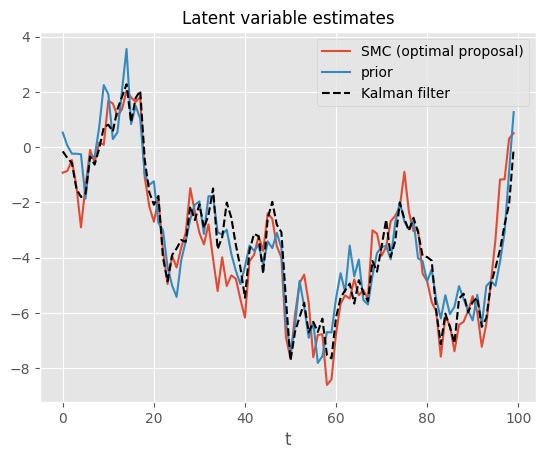

In [22]:
# Plotting estimates
plt.plot(x_opt.numpy(),label='SMC (optimal proposal)')
plt.plot(x_prior.numpy(),label='prior')
plt.plot(X_hat,label='Kalman filter',c='black',ls='--')
plt.xlabel('t')
plt.title('Latent variable estimates',size=12)
plt.legend()

(0.0, 1000.0)

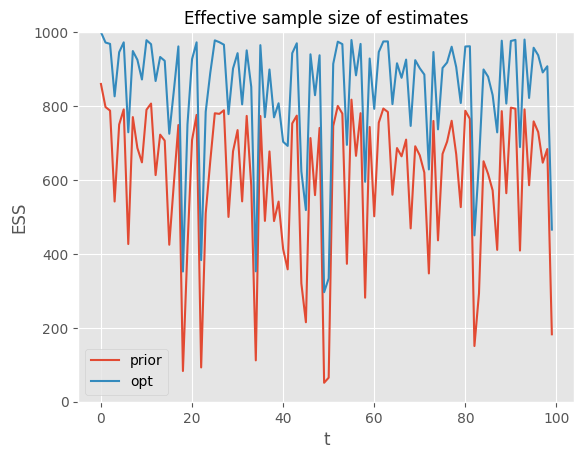

In [23]:
# Plotting ESS
ESS_opt = ESS(log_w_opt)
plt.plot(ESS_prior,label='prior')
plt.plot(ESS_opt, label='opt')
plt.legend()
plt.title('Effective sample size of estimates',size=12)
plt.xlabel('t')
plt.ylabel('ESS')
plt.ylim((0,1000))

In [24]:
opt_lik = log_marginal_likelihood(log_w_opt)

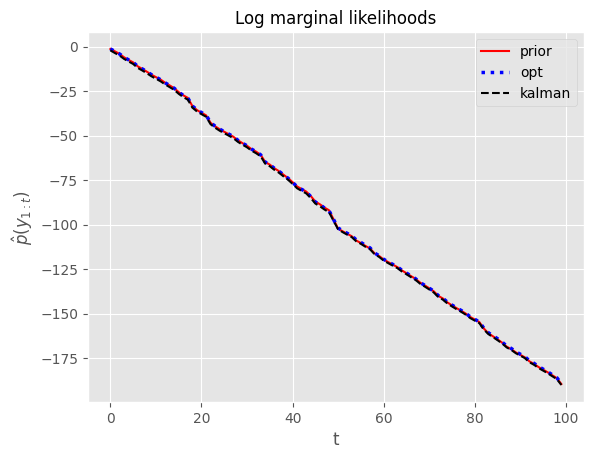

In [25]:
plt.plot(prior_lik, label='prior',c='red')
plt.plot(opt_lik, label='opt',ls='dotted',c='blue',lw=2.5)
plt.plot(kalman_lik, label='kalman',ls='--',c='black')
plt.title("Log marginal likelihoods",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
plt.legend()

Text(0.5, 1.0, 'Latent variable estimates')

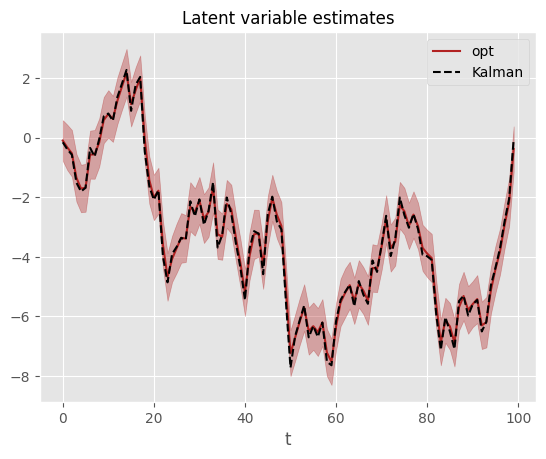

In [26]:
mu = x_part_opt.detach().mean(axis=1)
s = x_part_opt.detach().std(axis=1)
y1 = (mu - s).reshape(100,)
y2 = (mu + s).reshape(100,)

plt.plot(mu, label='opt',c='firebrick')
plt.fill_between(x=range(100), y1=y1, y2=y2, alpha=.35,color='firebrick')
plt.plot(X_hat,ls='--',c='black',label="Kalman")
plt.legend()
plt.xlabel("t")
plt.title("Latent variable estimates",size=12)

## Variational SMC

In [27]:
# Functions to be used
def prior_VSMC(x, x_prev):
    return prior(x_prev).log_prob(x)

def likelihood_VSMC(y_t, x_t):
    return likelihood(x_t).log_prob(y_t)

def proposal_logpdf(x, x_prev, lambda_):
    if x_prev is None:
        return Normal(lambda_, 1).log_prob(x)
    else:
        return Normal(lambda_ * x_prev, 1).log_prob(x)

def proposal(x_prev, eps, lambda_):
    if x_prev is None:
        mu = lambda_
    else:
        mu = lambda_ * x_prev
    return eps + mu


In [28]:
# VSMC
def run_vsmc(y_seq, lambda_, N, T):
    latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal(None, eps, lambda_)
    x_particles[0] = x_t
    log_w[0] = (
        prior_VSMC(x_t, None) + likelihood_VSMC(y_seq[0], x_t) - proposal_logpdf(x_t, None, lambda_)
    ).squeeze()

    for t in range(1, T):
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        # print(w_prev)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal(x_prev, eps, lambda_)
        x_particles[t] = x_t

        log_w[t] = (
            prior_VSMC(x_t, x_prev) + likelihood_VSMC(y_seq[t], x_t) - proposal_logpdf(x_t, x_prev, lambda_)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    i = b_T
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, i]
        if t > 0:
            i = ancestors[t, i]
    
    return log_w, x_particles, ancestors, x_estimates


def surrogate_elbo(log_w):
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.size(1), dtype=torch.float32))
    return logZ.sum()

def train_vsmc(y_seq, T, N, n_steps=100, lr=1e-3):
    # Parameter to learn
    lambda_ = torch.nn.Parameter(torch.randn((1,)))
    optimizer = torch.optim.Adam([lambda_], lr=lr)
    history = []
    
    # Training loop
    for step in range(n_steps):
        optimizer.zero_grad()
        log_w,_,_,_ = run_vsmc(y_seq, lambda_, N, T=T)
        elbo = surrogate_elbo(log_w)
        loss = -elbo
        loss.backward()
        if step % 50 == 0:
            print(f"Step {step:03d} | ELBO: {elbo.item():.2f} | grad: {lambda_.grad.item():.4f}")
        optimizer.step()
        history.append(loss)
    print(f"Training finished!\nFinal loss: {loss.item()}")
    return history, lambda_


In [29]:
n_steps = 500
T=100
N = 1000
y_seq = [torch.tensor([i]) for i in Y]
start_time = time.time()
history, lambda_ = train_vsmc(y_seq, T, N, n_steps,lr=0.01)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time for training: {elapsed_time} s (~ {elapsed_time/n_steps} s/step)")

Step 000 | ELBO: -572.86 | grad: -303.8557
Step 050 | ELBO: -431.58 | grad: -393.0432
Step 100 | ELBO: -204.27 | grad: -258.0006
Step 150 | ELBO: -189.69 | grad: -119.4246
Step 200 | ELBO: -188.75 | grad: -566.8019
Step 250 | ELBO: -189.62 | grad: -556.8500
Step 300 | ELBO: -188.75 | grad: -315.7548
Step 350 | ELBO: -189.40 | grad: 69.0814
Step 400 | ELBO: -188.88 | grad: -354.5396
Step 450 | ELBO: -189.46 | grad: -153.2018
Training finished!
Final loss: 189.9716796875
Time for training: 77.04694867134094 s (~ 0.1540938973426819 s/step)


Text(0, 0.5, '-ELBO')

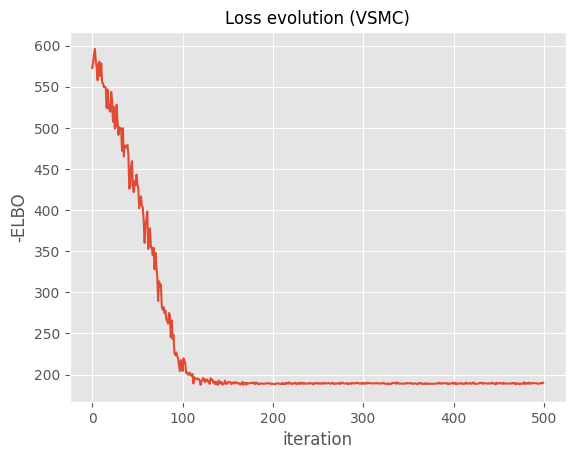

In [30]:
plt.plot([i.detach() for i in history])
plt.title("Loss evolution (VSMC)",size=12)
plt.xlabel("iteration")
plt.ylabel("-ELBO")

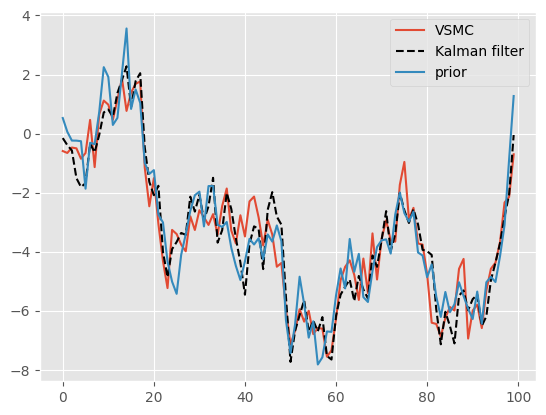

In [31]:
log_w_vsmc, x_part_vsmc, a_vsmc, x_vsmc = run_vsmc(y_seq, lambda_, N, 100)

plt.plot(x_vsmc.detach().numpy(),label='VSMC')
plt.plot(X_hat,label='Kalman filter',c='black',ls='--')
plt.plot(x_prior.numpy(), label="prior")
plt.legend()

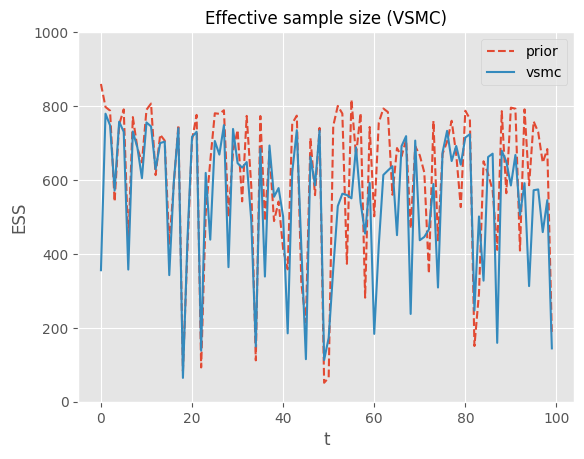

In [32]:
# Comparing ESS
plt.plot(ESS(log_w_prior),label='prior',ls='--')
plt.plot(ESS(log_w_vsmc).detach().numpy(),label='vsmc')
plt.ylim((0,N))
plt.xlabel("t")
plt.ylabel("ESS")
plt.title("Effective sample size (VSMC)",size=12)
plt.legend()

In [33]:
vsmc_lik = log_marginal_likelihood(log_w_vsmc)

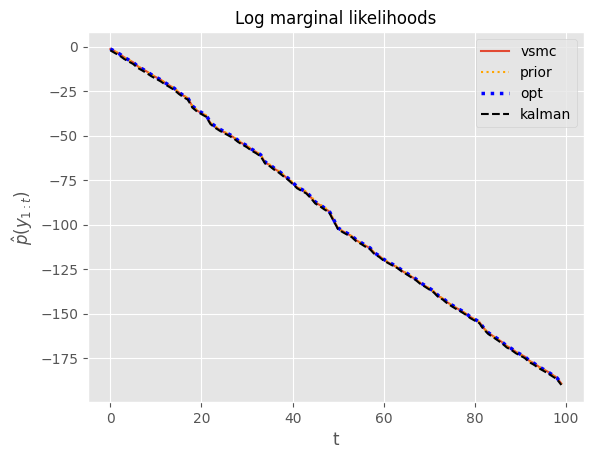

In [34]:
plt.plot(vsmc_lik.detach().numpy(), label='vsmc')
plt.plot(prior_lik, label='prior',c='orange',ls='dotted')
plt.plot(opt_lik, label='opt',ls='dotted',c='blue',lw=2.5)
plt.plot(kalman_lik, label='kalman',ls='--',c='black')
plt.title("Log marginal likelihoods",size=12)
plt.xlabel("t")
plt.ylabel(r"$\hat{p} (y_{1:t})$")
plt.legend()

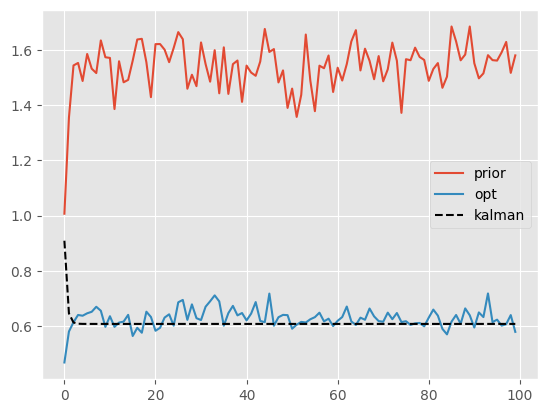

In [35]:
plt.plot(x_part_prior.std(axis=1)**2,label='prior')
plt.plot(x_part_opt.std(axis=1)**2,label='opt')
plt.plot(kalman_var, label='kalman', c='black',ls='--')
plt.legend()

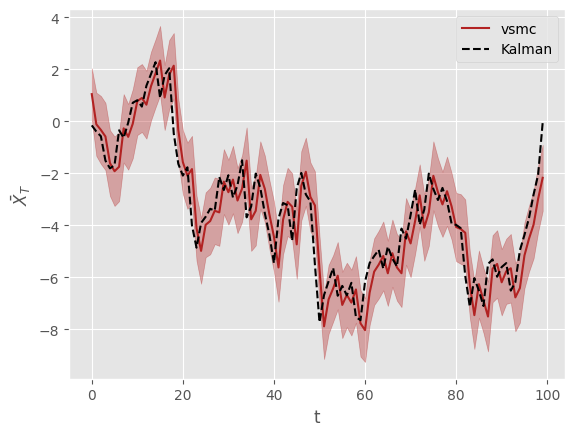

In [36]:
mu = x_part_vsmc.detach().mean(axis=1)
s = x_part_vsmc.detach().std(axis=1)
y1 = (mu - s).reshape(100,)
y2 = (mu + s).reshape(100,)

plt.plot(mu, label='vsmc',c='firebrick')
plt.fill_between(x=range(100), y1=y1, y2=y2, alpha=.35,color='firebrick')
plt.plot(X_hat,ls='--',c='black',label="Kalman")
plt.xlabel('t')
plt.ylabel(r"$\bar{X}_T$")
plt.legend()

---

## Variational SMC (unstable version)

In this section, I implement a version of VSMC considering a wider variational family, planned to be more flexible. However, it showed high instability and it seemed like the loss was not well behaved. I'm not sure if this is a matter of implementation or the real behavior of the loss, but I chose to keep this code here for documentation purposes.


In [37]:
class LinearProposal(nn.Module):
    def __init__(self, a, b=torch.tensor([0.0]), c=torch.tensor([0.0]), log_sigma=torch.tensor([1.0])):
        super().__init__()
        self.a = a #nn.Parameter(torch.tensor([0.5]))
        self.b = b #nn.Parameter(torch.tensor([0.5]))
        self.c = c #nn.Parameter(torch.tensor([0.0]))
        self.log_sigma = log_sigma #nn.Parameter(torch.tensor([0.0]))

    def forward(self, x_prev, y_t, eps):
        mu = self.a * x_prev + self.b * y_t + self.c
        std = torch.exp(self.log_sigma)
        return mu + std * eps

    def log_prob(self, x, x_prev, y_t):
        mu = self.a * x_prev + self.b * y_t + self.c
        std = torch.exp(self.log_sigma)
        return Normal(mu, std).log_prob(x)



def surrogate_elbo(log_w):
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.size(1), dtype=torch.float32))
    return logZ.sum()
    

In [38]:
# VSMC
def VSMC(y_seq, N, T, proposal, latent_dim = 1):
    # latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    # Reparametrization trick
    eps = torch.randn(N, latent_dim)
    x_t = proposal.forward(torch.tensor([0.0]), y_seq[0], eps)#, proposal_id)
    
    x_particles[0] = x_t
    log_w[0] = (
        prior(None).log_prob(x_t) 
        + likelihood(x_t).log_prob(y_seq[0])
        - proposal.log_prob(x_t, torch.tensor([0.0]), y_seq[0])#, proposal_id)
    ).squeeze()

    for t in range(1, T):
        
        w_prev = torch.softmax(log_w[t - 1], dim=0)
        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal.forward(x_prev, y_seq[t], eps)# lambda_)#, proposal_id)
        x_particles[t] = x_t

        log_w[t] = (
            prior(x_prev).log_prob(x_t) 
            + likelihood(x_t).log_prob(y_seq[t]) 
            - proposal.log_prob(x_t, x_prev, y_seq[t])#, proposal_id)
        ).squeeze()

    # Sample final trajectory
    w_T = torch.softmax(log_w[-1], dim=0)
    b_T = torch.multinomial(w_T, 1).item()
    
    # Trace back trajectory
    x_estimates = torch.zeros_like(x_particles[:, 0])
    i = b_T
    for t in reversed(range(T)):
        x_estimates[t] = x_particles[t, i]
        if t > 0:
            i = ancestors[t, i]

    return log_w, x_particles, ancestors, x_estimates


In [39]:
def train_vsmc(y_seq, T, N, n_steps=100, lr=1e-3):

    a = nn.Parameter(torch.randn((1,)))
    b = nn.Parameter(torch.tensor([0.0]))
    c = nn.Parameter(torch.tensor([0.0]))
    log_sigma = nn.Parameter(torch.tensor([0.0]))
    
    # b = torch.tensor([0.0])
    # c = torch.tensor([0.0])
    # log_sigma = torch.tensor([1.0])
    
    proposal = LinearProposal(a, b, c, log_sigma)
    
    optimizer = torch.optim.Adam(proposal.parameters(), lr=lr)
    history = []
    
    # Training loop
    for step in range(n_steps):
        optimizer.zero_grad()
        log_w,_,_,_ = VSMC(y_seq, N, T, proposal)#, proposal_id)
        elbo = surrogate_elbo(log_w)
        loss = -elbo
        loss.backward()
        optimizer.step()
        if step % 10 == 0:
            with torch.no_grad():
                print(f"Step {step:03d} | ELBO: {elbo.item():.2f}")# | grad: {proposal.paramaters().grad.item():.4f}")
                # print(proposal.a, proposal.b, proposal.log_sigma)
            # print(lambda_,'\n')
        history.append(loss.item())
    print(f"Training finished!\nFinal loss: {loss.item()}")
    return history, proposal

In [41]:
n_steps = 150
T = 100
N = 1000
stat_time = time.time()
history, proposal = train_vsmc(y_seq, T, N, n_steps,lr=0.1)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time for training: {elapsed_time} s (~ {elapsed_time/n_steps} s/step)")

Step 000 | ELBO: -915.24
Step 010 | ELBO: -960.18
Step 020 | ELBO: -853.86
Step 030 | ELBO: -921.92
Step 040 | ELBO: -910.08
Step 050 | ELBO: -837.02
Step 060 | ELBO: -908.14
Step 070 | ELBO: -846.14
Step 080 | ELBO: -874.62
Step 090 | ELBO: -835.91
Step 100 | ELBO: -790.17
Step 110 | ELBO: -830.03
Step 120 | ELBO: -818.06
Step 130 | ELBO: -612.61
Step 140 | ELBO: -624.33
Training finished!
Final loss: 747.6988525390625
Time for training: 110.72083020210266 s (~ 0.7381388680140177 s/step)


Text(0.5, 1.0, 'Loss history')

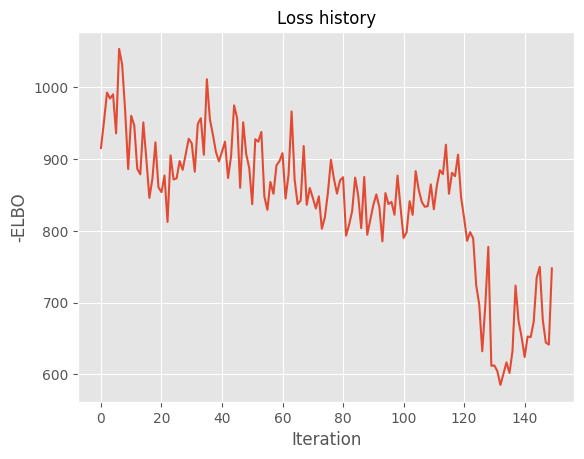

In [42]:
plt.plot(history)
plt.ylabel("-ELBO")
plt.xlabel("Iteration")
plt.title("Loss history",size=12)

In [43]:
N = 1000
T = 100
log_w_vsmc_lin, x_part_vsmc_lin, a_vsmc_lin, x_vsmc_lin = VSMC(y_seq, N, T, proposal)

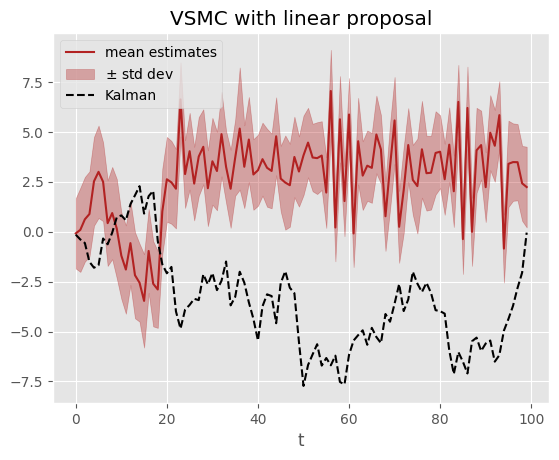

In [44]:
mu = x_part_vsmc_lin.detach().mean(axis=1)
s = x_part_vsmc_lin.detach().std(axis=1)
y1 = (mu - s).reshape(100,)
y2 = (mu + s).reshape(100,)

plt.plot(mu, label='mean estimates',c='firebrick')
plt.fill_between(x=range(100), y1=y1, y2=y2, alpha=.35,color='firebrick', label=r"$\pm$ std dev")
plt.plot(X_hat,ls='--',c='black',label="Kalman")
plt.xlabel('t')
plt.title('VSMC with linear proposal')
# plt.ylabel(r"$\bar{X}_T$")
plt.legend()

(0.0, 1000.0)

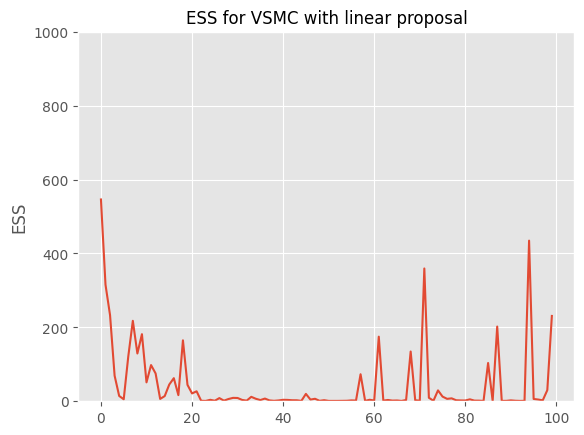

In [45]:
plt.plot(ESS(log_w_vsmc_lin).detach().numpy())
plt.title('ESS for VSMC with linear proposal',size=12)
plt.ylabel("ESS")
plt.ylim((0,1000))

100%|██████████| 100/100 [00:10<00:00,  9.23it/s]


Text(0.5, 1.0, 'ELBO landscape')

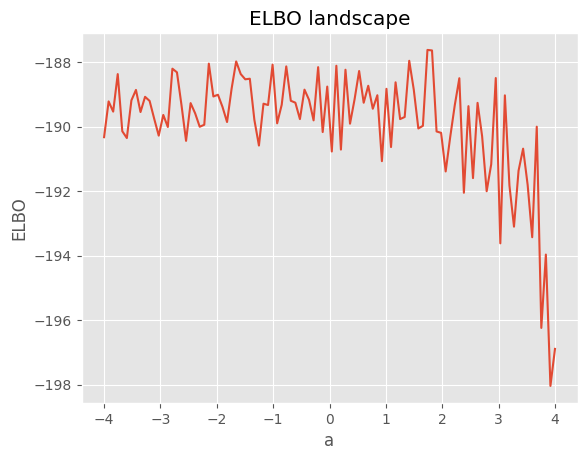

In [47]:
# Plotting an approximation of ELBO for fixed all but one
# values of parameters

# small_y = y_seq[:5]  # 

lambdas = torch.linspace(-4, 4, 100)
elbos = []

for val in tqdm(lambdas):
    lambda_test = torch.tensor([val])
    proposal_test = LinearProposal(
        a=torch.tensor([0.5]),
        c=lambda_test
    )
    log_w, _, _, _ = VSMC(y_seq, 1000, 100, proposal_test)
    elbos.append(surrogate_elbo(log_w).item())

plt.plot(lambdas.numpy(), elbos)
plt.xlabel("a")
plt.ylabel("ELBO")
plt.title("ELBO landscape")

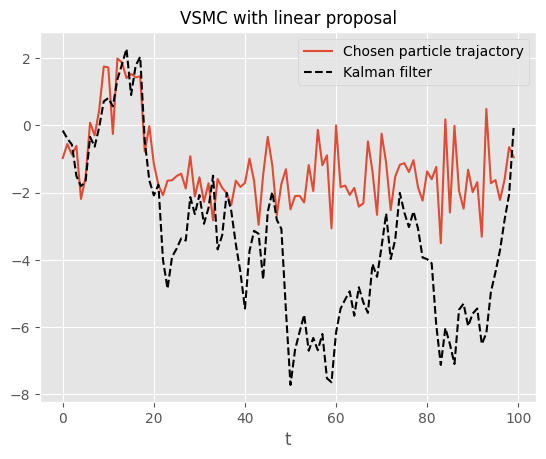

In [48]:
plt.plot(x_vsmc_lin.detach().numpy(),label='Chosen particle trajactory')
plt.plot(X_hat,label='Kalman filter',c='black',ls='--')
# plt.plot(x_prior.numpy(), label="SMC with prior")
# plt.plot(x_opt.numpy(), label="SMC optimal")
plt.title("VSMC with linear proposal", size=12)
plt.xlabel('t')
plt.legend()

---

## Normalizing Flow-based VSMC

Finally, we implement a normalizing flow for choosing a proposal for VSMC.

In [ ]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, context_dim=None):
        super().__init__()
        total_in = in_dim + (context_dim if context_dim is not None else 0)
        self.net = nn.Sequential(
            nn.Linear(total_in, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, in_dim)
        )

    def forward(self, x, context=None):
        if context is not None:
            x = torch.cat([x, context], dim=-1)
        return self.net(x)

class RealNVPLayer(nn.Module):
    def __init__(self, dim, mask, context_dim=None):
        super().__init__()
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.scale_net = MLP(dim, context_dim=context_dim)
        self.translate_net = MLP(dim, context_dim=context_dim)

    def forward(self, x, context=None):
        x_masked = x * self.mask
        # Trying to regularize network outputs
        s_ = torch.tanh(self.scale_net(x_masked, context)) * 2.0
        s = s_ * (1 - self.mask)

        t_ = torch.tanh(self.translate_net(x_masked, context)) * 2.0
        t = t_ * (1 - self.mask)

        # s = self.scale_net(x_masked, context) * (1 - self.mask)
        # t = self.translate_net(x_masked, context) * (1 - self.mask)
        return x_masked + (1 - self.mask) * (x * torch.exp(s) + t)

    def inverse(self, y, context=None):
        y_masked = y * self.mask
        # Trying to regularize network outputs
        s_ = torch.tanh(self.scale_net(y_masked, context)) * 2.0
        s = s_ * (1 - self.mask)
        t = self.translate_net(y_masked, context) * (1 - self.mask)
        x = y_masked + (1 - self.mask) * ((y - t) * torch.exp(-s))
        log_det_J = torch.sum(s, dim=1)
        return x, log_det_J

class RealNVP(nn.Module):
    def __init__(self, dim, n_layers, base_dist, context_dim=None):
        super().__init__()
        self.dim = dim
        self.base_dist = base_dist
        self.layers = nn.ModuleList([
            RealNVPLayer(dim, mask=torch.tensor([i % 2, (i + 1) % 2], dtype=torch.float32), context_dim=context_dim)
            for i in range(n_layers)
        ])

    def forward(self, z, context=None):
        for i, layer in enumerate(self.layers):
            z = layer(z, context)
            if torch.isnan(z).any() or torch.isinf(z).any():
                print(f"Flow z has NaN/Inf after layer {i}")
        return z

    def inverse(self, x, context=None):
        log_det = torch.zeros(x.size(0), device=x.device)
        for layer in reversed(self.layers):
            x, log_j = layer.inverse(x, context)
            log_det -= log_j

        if torch.isnan(x).any() or torch.isinf(x).any():
            print("Flow z has NaN/Inf")

        if torch.isnan(log_det).any() or torch.isinf(log_det).any():
            print("Flow log_det has NaN/Inf")

        return x, log_det

    def log_prob(self, x, context=None):
        
        z, log_det = self.inverse(x, context)

        # z_check, log_det = flow.inverse(x_t, context=x_prev)

        if torch.isnan(z).any() or torch.isinf(z).any():
            print("Flow z has NaN/Inf")

        if torch.isnan(log_det).any() or torch.isinf(log_det).any():
            print("Flow log_det has NaN/Inf")

        clamped_z = torch.clamp(z, min=-1e6, max=1e6)
        # print(
        # ed_z)

        base_log_prob = self.base_dist.log_prob(clamped_z)

        return base_log_prob + log_det
        # return self.base_dist.log_prob(z) + log_det

    def sample(self, n_samples, context=None):
        z = self.base_dist.sample((n_samples, self.dim)).to(next(self.parameters()).device)
        return self.forward(z, context)



In [52]:
# === Prior and Likelihood ===
def prior_nf(x_t, x_prev):
    return MultivariateNormal(torch.zeros_like(x_t), torch.eye(latent_dim)).log_prob(x_t)

def likelihood_nf(y_t, x_t):
    return MultivariateNormal(x_t, 0.1 * torch.eye(latent_dim)).log_prob(y_t)

# === Proposal Wrappers ===
def proposal_nf(x_prev, eps, flow):
    if x_prev is None:
        x_prev = torch.zeros_like(eps)
    return flow.forward(eps, context=x_prev)


def proposal_nf_logpdf(x_t, x_prev, flow):
    if x_prev is None:
        x_prev = torch.zeros_like(x_t)
    return flow.log_prob(x_t, context=x_prev)


In [53]:
# === VSMC with ELBO ===
def vsmc_nf(y_seq, N, T, flow):
    latent_dim = y_seq[0].size(0)
    log_w = torch.zeros(T, N)
    x_particles = torch.zeros(T, N, latent_dim)
    ancestors = torch.zeros(T, N, dtype=torch.long)

    eps = torch.randn(N, latent_dim)
    x_t = proposal_nf(None, eps, flow)
    x_particles[0] = x_t
    log_w[0] = prior_nf(x_t, None) + likelihood_nf(y_seq[0], x_t) - proposal_nf_logpdf(x_t, None, flow)

    for t in range(1, T):
        log_w_prev = log_w[t - 1]
        log_w_prev = log_w_prev - torch.max(log_w_prev)  # stabilize softmax
        w_prev = torch.softmax(log_w_prev, dim=0)
        w_prev = torch.clamp(w_prev, min=1e-8)
        w_prev = w_prev / w_prev.sum()

        a_t = torch.multinomial(w_prev, N, replacement=True)
        ancestors[t] = a_t

        x_prev = x_particles[t - 1, a_t]
        eps = torch.randn(N, latent_dim)
        x_t = proposal_nf(x_prev, eps, flow)
        x_particles[t] = x_t

        log_w[t] = prior_nf(x_t, x_prev) + likelihood_nf(y_seq[t], x_t) - proposal_nf_logpdf(x_t, x_prev, flow)

    # logZ = torch.logsumexp(log_w[-1], dim=0) - torch.log(torch.tensor(N, dtype=torch.float))
    # logZ = torch.logsumexp(log_w, dim=1) - np.log(N) * torch.ones(T)

    # Must be negative:
    logZ = torch.logsumexp(log_w, dim=1) - torch.log(torch.tensor(log_w.shape[1], dtype=torch.float32))
    # return logZ_t.sum()
    elbo = torch.clamp(logZ, max = 0).sum()
    return elbo, log_w, x_particles, ancestors


The data must be at least 2 dimensional in order for the RealNVP to make sense. Thus, we will add a new dimension to data by two different approaches and compare them. First, we assign zeros to every entry in the new dimension; second, we repeat the data in the new dimension.

In [54]:
# Assign zeros to new dimension
y_seq_zeros = torch.stack([torch.cat((i, torch.tensor([0]))) for i in y_seq])
print(y_seq_zeros[:10],'\n')  # printing the first 10 values

# Repeat data in new dimension
y_seq_repeat = torch.stack([torch.cat((i, i)) for i in y_seq])
print(y_seq_repeat[:10],'\n')  # printing the first 10 values

tensor([[-0.1666,  0.0000],
        [-0.5247,  0.0000],
        [-0.6954,  0.0000],
        [-2.1302,  0.0000],
        [-2.0467,  0.0000],
        [-1.6577,  0.0000],
        [ 0.4692,  0.0000],
        [-0.8291,  0.0000],
        [ 0.3087,  0.0000],
        [ 1.2102,  0.0000]]) 

tensor([[-0.1666, -0.1666],
        [-0.5247, -0.5247],
        [-0.6954, -0.6954],
        [-2.1302, -2.1302],
        [-2.0467, -2.0467],
        [-1.6577, -1.6577],
        [ 0.4692,  0.4692],
        [-0.8291, -0.8291],
        [ 0.3087,  0.3087],
        [ 1.2102,  1.2102]]) 



In [55]:
lr = 1e-4
n_epochs = 100
# latent_dim = 2

history = []

# flow = RealNVP(dim=latent_dim, n_layers=4, base_dist=base_dist, context_dim=context_dim)


latent_dim = 2
context_dim = latent_dim
base_dist = MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))

flow = RealNVP(dim=latent_dim, n_layers=3, base_dist=base_dist, context_dim=context_dim)


# === Training Loop ===
start_time = time.time()
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    logZ, _, _, _ = vsmc_nf(y_seq_zeros, N=N, T=T, flow=flow)
    loss = -logZ
    # print(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5.0)
    optimizer.step()
    history.append(loss.item()) 
    # if epoch % 10 == 0:
    print(f"Epoch {epoch}: ELBO = {logZ.item():.4f}")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time for training: {elapsed_time} s (~ {elapsed_time/n_epochs} s/step)")

Epoch 0: ELBO = -3922.3318
Epoch 1: ELBO = -3494.2402
Epoch 2: ELBO = -3269.6919
Epoch 3: ELBO = -2934.6721
Epoch 4: ELBO = -2790.8440
Epoch 5: ELBO = -2609.8110
Epoch 6: ELBO = -2296.4229
Epoch 7: ELBO = -2064.5520
Epoch 8: ELBO = -1785.0012
Epoch 9: ELBO = -1532.5442
Epoch 10: ELBO = -1288.3250
Epoch 11: ELBO = -1155.9042
Epoch 12: ELBO = -1031.1342
Epoch 13: ELBO = -1035.4309
Epoch 14: ELBO = -1037.3684
Epoch 15: ELBO = -1044.5253
Epoch 16: ELBO = -1047.8682
Epoch 17: ELBO = -1049.4625
Epoch 18: ELBO = -1045.3549
Epoch 19: ELBO = -1047.0149
Epoch 20: ELBO = -1042.6857
Epoch 21: ELBO = -1030.4357
Epoch 22: ELBO = -1032.7751
Epoch 23: ELBO = -1025.6022
Epoch 24: ELBO = -1015.1496
Epoch 25: ELBO = -1010.1657
Epoch 26: ELBO = -1009.1862
Epoch 27: ELBO = -988.5443
Epoch 28: ELBO = -978.4190
Epoch 29: ELBO = -1014.7591
Epoch 30: ELBO = -974.0792
Epoch 31: ELBO = -1005.7975
Epoch 32: ELBO = -999.0869
Epoch 33: ELBO = -992.9873
Epoch 34: ELBO = -989.1195
Epoch 35: ELBO = -949.2659
Epoch 36:

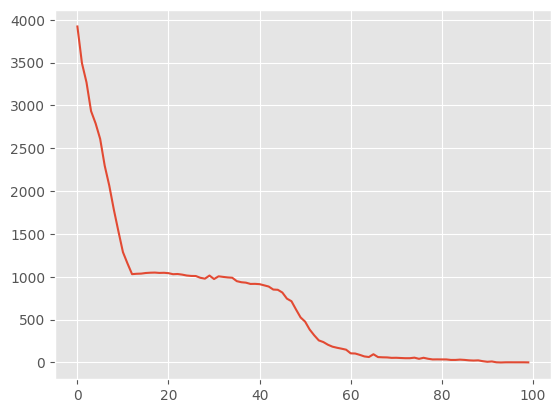

In [56]:
plt.plot(history)

In [57]:
elbo_nf, log_w_nf, x_particles_nf, ancestors_nf = vsmc_nf(y_seq_zeros, N=N, T=T, flow=flow)

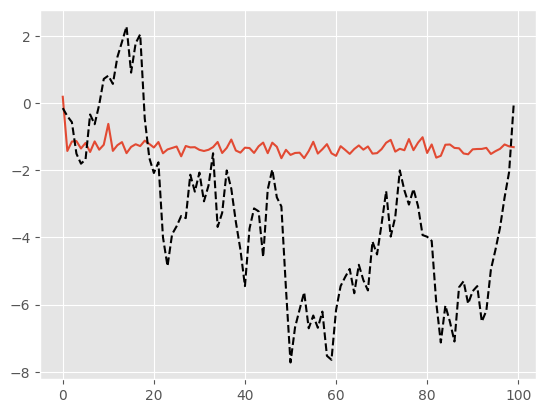

In [58]:
plt.plot(x_particles_nf.mean(axis=1)[:,0].detach().numpy())
plt.plot(X_hat, ls='--', c='black')

(0.0, 1000.0)

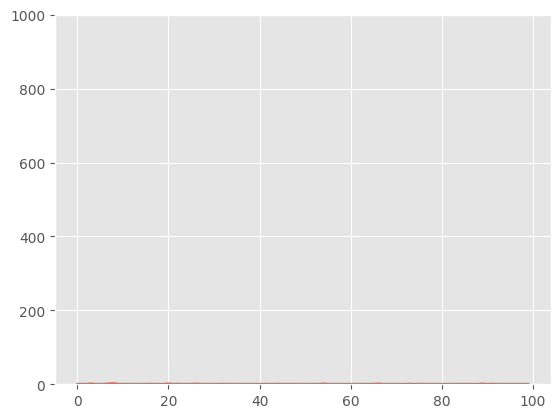

In [59]:
plt.plot(ESS(log_w_nf).detach().numpy())
plt.ylim((0,1000))


In [60]:
lr = 1e-4
n_epochs = 100
# latent_dim = 2

history = []

# flow = RealNVP(dim=latent_dim, n_layers=4, base_dist=base_dist, context_dim=context_dim)


latent_dim = 2
context_dim = latent_dim
base_dist = MultivariateNormal(torch.zeros(latent_dim), torch.eye(latent_dim))

flow = RealNVP(dim=latent_dim, n_layers=3, base_dist=base_dist, context_dim=context_dim)


# === Training Loop ===
start_time = time.time()
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    logZ, _, _, _ = vsmc_nf(y_seq_repeat, N=N, T=T, flow=flow)
    loss = -logZ
    # print(loss)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(flow.parameters(), max_norm=5.0)
    optimizer.step()
    history.append(loss.item()) 
    # if epoch % 10 == 0:
    print(f"Epoch {epoch}: ELBO = {logZ.item():.4f}")
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Time for training: {elapsed_time} s (~ {elapsed_time/n_epochs} s/step)")

Epoch 0: ELBO = -11248.3027
Epoch 1: ELBO = -10500.6943
Epoch 2: ELBO = -10341.5508
Epoch 3: ELBO = -9874.0195
Epoch 4: ELBO = -8936.7842
Epoch 5: ELBO = -8392.4443
Epoch 6: ELBO = -7658.6377
Epoch 7: ELBO = -6810.3989
Epoch 8: ELBO = -6295.7207
Epoch 9: ELBO = -5660.4160
Epoch 10: ELBO = -5314.9131
Epoch 11: ELBO = -4755.2549
Epoch 12: ELBO = -4283.2974
Epoch 13: ELBO = -3825.7036
Epoch 14: ELBO = -3383.7334
Epoch 15: ELBO = -2891.1887
Epoch 16: ELBO = -2633.2422
Epoch 17: ELBO = -2401.2983
Epoch 18: ELBO = -2224.1582
Epoch 19: ELBO = -2097.0173
Epoch 20: ELBO = -2046.1360
Epoch 21: ELBO = -2070.7021
Epoch 22: ELBO = -2027.4717
Epoch 23: ELBO = -1975.3864
Epoch 24: ELBO = -1974.2622
Epoch 25: ELBO = -1975.6265
Epoch 26: ELBO = -1970.8097
Epoch 27: ELBO = -1990.7993
Epoch 28: ELBO = -1979.3185
Epoch 29: ELBO = -1968.8458
Epoch 30: ELBO = -1984.9949
Epoch 31: ELBO = -1974.2542
Epoch 32: ELBO = -1981.0161
Epoch 33: ELBO = -1964.2673
Epoch 34: ELBO = -1980.8879
Epoch 35: ELBO = -1993.2415

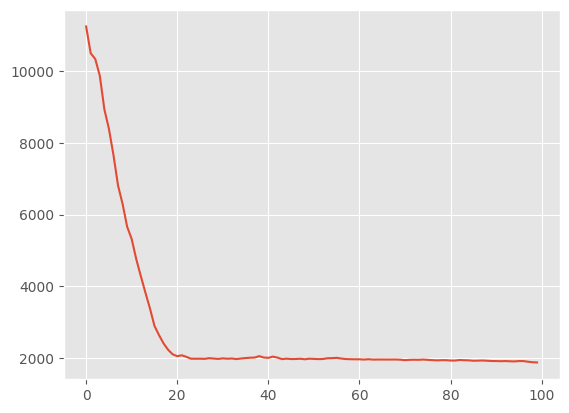

In [61]:
plt.plot(history)

In [62]:
elbo_nf_2, log_w_nf_2, x_particles_nf_2, ancestors_nf_2 = vsmc_nf(y_seq_repeat, N=N, T=T, flow=flow)

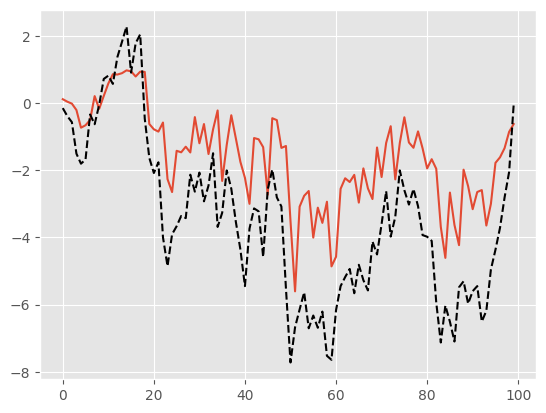

In [63]:
plt.plot(x_particles_nf_2.mean(axis=1)[:,0].detach().numpy())
plt.plot(X_hat, ls='--', c='black')

/tmp/ipykernel_9755/2630475906.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


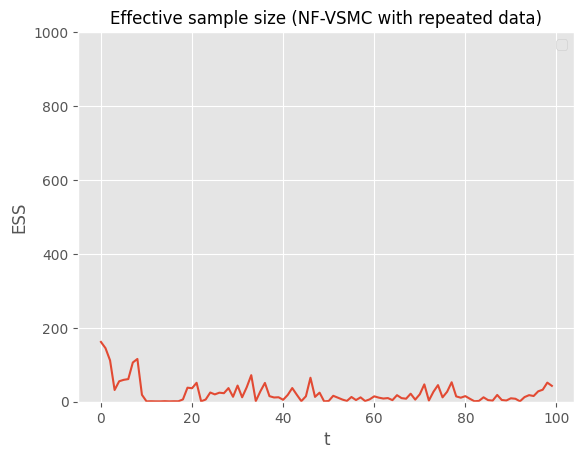

In [69]:
# Comparing ESS
# plt.plot(ESS(log_w_nf_2),label='prior',ls='--')
plt.plot(ESS(log_w_nf_2).detach().numpy())
plt.ylim((0,1000))
plt.xlabel("t")
plt.ylabel("ESS")
plt.title("Effective sample size (NF-VSMC with repeated data)",size=12)
plt.legend()

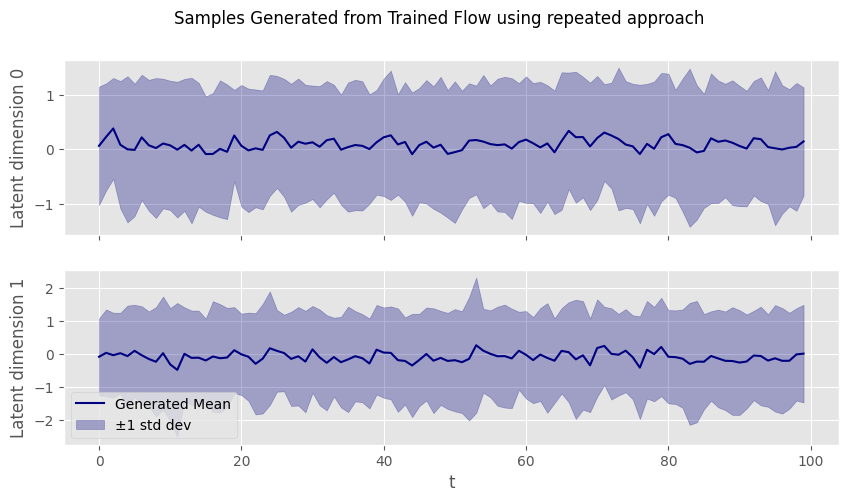

In [64]:
flow.eval()  # set model to eval mode

# Number of samples (particles) to generate per timestep
N = 100

# If your flow is conditional on previous state (context), generate a sequence:
with torch.no_grad():
    # Start with zeros or random context for t=0
    x_prev = torch.zeros(N, latent_dim).to(next(flow.parameters()).device)

    generated_particles = []

    for t in range(T):
        # Sample base noise from standard normal
        eps = torch.randn(N, latent_dim).to(x_prev.device)
        
        # Generate samples with context = previous latent (or None for t=0)
        x_t = flow.forward(eps, context=x_prev)
        generated_particles.append(x_t.cpu())
        
        # Update context
        x_prev = x_t

    # Stack into (T, N, latent_dim)
    generated_particles = torch.stack(generated_particles)

# Now plot mean and uncertainty for latent dimension 0

fig, ax = plt.subplots(2,1,figsize=(10,5), sharex=True)

for i in range(2):
    mu = generated_particles[..., i].mean(dim=1).numpy()
    std = generated_particles[..., i].std(dim=1).numpy()
    time = range(T)

    ax[i].plot(time, mu, label='Generated Mean', color='navy')
    ax[i].fill_between(time, mu - std, mu + std, color='navy', alpha=0.3, label='±1 std dev')
    ax[i].set_ylabel(f'Latent dimension {i}')
ax[1].set_xlabel('t')
plt.suptitle('Samples Generated from Trained Flow using repeated approach',size=12)
plt.legend()
plt.grid(True)
plt.show()


---

# References:

\[1\] T. Lacey, "Tutorial: The Kalman Filter". Accessed: Jul. 09, 2025. \[Online\]. Available: https://web.mit.edu/kirtley/kirtley/binlustuff/literature/control/Kalman%20filter.pdf.

\[2\] C. A. Naesseth, S. W. Linderman, R. Ranganath, and D. M. Blei, "Variational Sequential Monte
Carlo." \[Online\]. Available: https://arxiv.org/abs/1705.11140.